# Import Libraries

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

# Download Data

In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-10-05 19:06:55--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.009s  

2021-10-05 19:06:55 (7.54 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



# Basic Functions

In [4]:
def plot_time_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end],
           series[start:end],
           format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

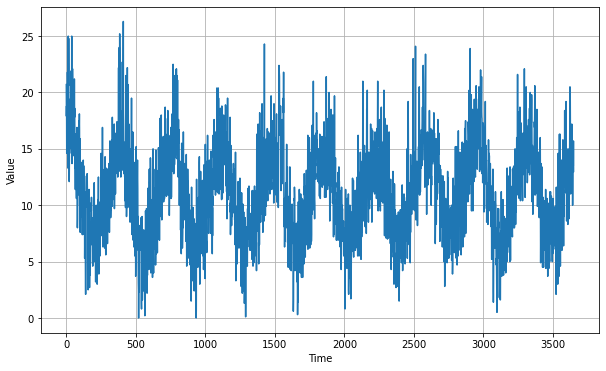

In [5]:
time_steps = []
temps = []

with open('/tmp/daily-min-temperatures.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)

  step = 0
  for row in reader:
    temps.append(float(row[1]))
    time_steps.append(step)
    step = step + 1


series = np.array(temps)
time = np.array(time_steps)

plt.figure(figsize=(10,6))
plot_time_series(time, series)

# Splitting Data

In [6]:
split_time = 2500

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

print(len(time_train), len(x_train))
print(len(time_valid), len(x_valid))

2500 2500
1150 1150


# Windowed Dataset

In [8]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Creating a Model

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           strides=1, padding='causal',
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400.0)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
    metrics=['mae']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [13]:
history = model.fit(train_set,
                    epochs=100,
                    callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 8s 348ms/step - loss: 65.6189 - mae: 66.1189
Epoch 2/100
10/10 [==============================] - 4s 346ms/step - loss: 64.2359 - mae: 64.7359
Epoch 3/100
10/10 [==============================] - 4s 343ms/step - loss: 62.1026 - mae: 62.6025
Epoch 4/100
10/10 [==============================] - 4s 340ms/step - loss: 59.4832 - mae: 59.9831
Epoch 5/100
10/10 [==============================] - 4s 337ms/step - loss: 56.4483 - mae: 56.9482
Epoch 6/100
10/10 [==============================] - 4s 338ms/step - loss: 53.0065 - mae: 53.5064
Epoch 7/100
10/10 [==============================] - 4s 332ms/step - loss: 49.1628 - mae: 49.6626
Epoch 8/100
10/10 [==============================] - 4s 324ms/step - loss: 44.9292 - mae: 45.4289
Epoch 9/100
10/10 [==============================] - 4s 345ms/step - loss: 40.3981 - mae: 40.8977
Epoch 10/100
10/10 [==============================] - 4s 346ms/step - loss: 35.7139 - mae: 36.2134
Epoch 11/100
10/10 

(1e-08, 0.0001, 0.0, 60.0)

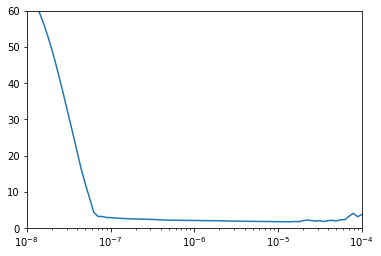

In [14]:
plt.semilogx(history.history["lr"], 
             history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           strides=1, padding='causal',
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400.0)
])


model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
    metrics=['mae']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense_3 (Dense)              (None, None, 30)          1950      
_________________________________________________________________
dense_4 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1)          

In [16]:
history = model.fit(train_set,
                    epochs=150)

Epoch 1/150
10/10 [==============================] - 8s 353ms/step - loss: 44.3520 - mae: 44.8476
Epoch 2/150
10/10 [==============================] - 4s 340ms/step - loss: 4.8863 - mae: 5.3658
Epoch 3/150
10/10 [==============================] - 4s 337ms/step - loss: 2.8422 - mae: 3.3088
Epoch 4/150
10/10 [==============================] - 4s 321ms/step - loss: 2.2503 - mae: 2.7117
Epoch 5/150
10/10 [==============================] - 4s 352ms/step - loss: 2.0619 - mae: 2.5197
Epoch 6/150
10/10 [==============================] - 4s 344ms/step - loss: 1.8950 - mae: 2.3500
Epoch 7/150
10/10 [==============================] - 4s 349ms/step - loss: 1.8398 - mae: 2.2926
Epoch 8/150
10/10 [==============================] - 4s 332ms/step - loss: 1.7880 - mae: 2.2401
Epoch 9/150
10/10 [==============================] - 4s 348ms/step - loss: 1.7514 - mae: 2.2019
Epoch 10/150
10/10 [==============================] - 4s 336ms/step - loss: 1.7365 - mae: 2.1859
Epoch 11/150
10/10 [=================

In [17]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
forecast = forecast[split_time - window_size:-1, -1, 0]

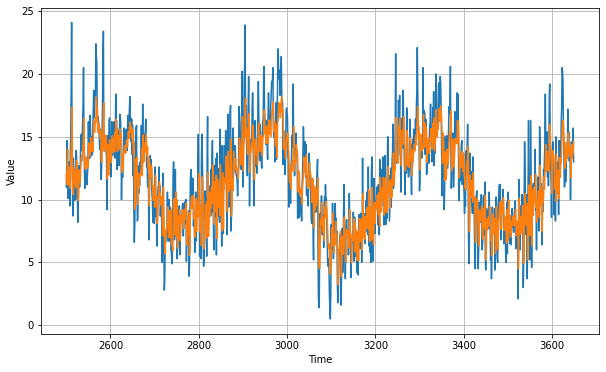

In [18]:
plt.figure(figsize=(10, 6))
plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, forecast)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

1.8066896

In [21]:
print(forecast)

[12.012839  11.215808  12.812215  ... 13.702059  13.7134495 14.655442 ]
